In [20]:
# %matplotlib ipympl
# %matplotlib notebook
# %matplotlib qt
import pandas
import pathlib
import re
import numpy as np
# import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt
from matplotlib import animation
import json
from typing import Tuple

cwd = pathlib.Path.cwd()

G = 6.67408e-11
SCALE = 1
YEARS = 1
h = 60*60*24/SCALE  # number of seconds in a day
tsteps = 365*YEARS*SCALE  # number of days
X = Rn = 0
Y = Vn = 1


Classes

In [21]:
class Wanderer():
    '''
    Yes there are a number of variables that with Python I can easily access, but I made them private
    with methods to get ahold of them for purposes of 1) clarity and 2) safty. I don't want to accidentally
    access a variable, 
    '''
    def __init__(self, name: str, mass: float, x0: float, y0: float, vx0: float, vy0: float) -> None:

        self._name = name
        self._mass = mass
        self.rn = np.array([[x0, y0]])
        self.vn = np.array([[vx0, vy0]])
        self.clear_drdv()

        self._store_dv = np.zeros(shape = (1, 2))
        self._store_dr = np.zeros(shape = (1, 2))

    
    def clear_drdv(self):
        self._dr = np.zeros(shape = (4, 2))
        self._dv = np.zeros(shape = (4, 2))

    
    def store_drdv(self, dr: np.array, dv: np.array):
        '''
        '''
        self._store_dr = dr
        self._store_dv = dv


    def set_drdv(self, k: int, dr: list, dv: list):
        '''
        '''
        self._dr[k] = dr
        self._dv[k] = dv

    
    def GMass(self, G):
        self.gass = self._mass * G


    def get_drdv(self) -> Tuple[np.array, np.array]:
        '''
        Just returns the dr and dv attributes.
        '''
        return self._dr, self._dv
    

    def get_kth(self, k: int) -> Tuple[np.array, np.array]:
        '''
        '''
        return self._dr[k], self._dv[k]
    

    def update_rnvn(self, rn, vn):
        '''
        '''
        self.rn = np.vstack([self.rn, rn])
        self.vn = np.vstack([self.vn, vn])



In [22]:
class NBodies():
    '''
    '''
    def __init__(self, system:tuple, tsteps: int, h: float, G: float, delta: float = 1.0e-6) -> None:

        self.system = system
        self.tsteps = tsteps
        self.h, self.h0 = h, h
        self.G = G
        self.delta = delta
        self.to_many_iters = 0


    def orbits(self):
        '''
        This executes the iterations. First it sets the GMass, then it executes each time step, followed by finding the n+1 value
        of the function.

        It may seem overly complex to do it like this, where each step executes 
        '''
        body: Wanderer

        for body in self.system:
            body.GMass(self.G)
            self.clear_drdv()

        for t in range(self.tsteps):
            nn = self.n_plusone(t, self.h)
            self.update_position(nn)
            self.clear_drdv()


    def update_position(self, nn: dict):
        '''
        '''
        body: Wanderer
        for body in self.system:
            body.update_rnvn(nn[body._name][Rn], nn[body._name][Vn])


    def clear_drdv(self):
        '''
        Invokes the clear drdv method for each body, making sure they are all set to 0 before the rest of the iteration starts
        '''
        body: Wanderer
        for body in self.system:
            body.clear_drdv()



    def adaptive_time_step(self, t: int, max_attempts = 100):
        '''
        Finds the global h and adjusts that. It will fine to to the smallest needed h and expand only when needed.
        So basically look at each possible need for h, find the one with the best error, and use that for everyone

        https://www.youtube.com/watch?v=7eUyxD9f3dE

        A good youtube video on the adaptive method.

        The reason for the r1 = f(r0), r1 = f(r1), r2 = f(r0) is because we want to compare a double step vs two steps
        '''
        target_met = False

        for _ in range(max_attempts):  # do only a certain number of times, I'm testing right now so I don't want to get stuck doing this forever

            nn0 = self.n_plusone(t, self.h)
            self.update_position(nn0)
            nn1 = self.n_plusone(t + 1, self.h)
            self.update_position(nn1)
            nn2 = self.n_plusone(t, 2*self.h)

            self.error(nn1, nn2)

            target_met = True

            if target_met:
                self.update_position(nn1)
        else:
            self.to_many_iters += 1
            self.update_position(nn1)


    def error(self, vec1: dict, vec2: dict, delta = 1.0e-6):
        '''
        '''
        
        def euc_dist(x: float):
            return np.sqrt(np.dot(x, x))

        dict2vect = lambda x: np.array(list(x.values()))[:, Rn]

        vec1 = dict2vect(vec1)
        vec2 = dict2vect(vec2)

        diff = np.apply_along_axis(euc_dist, 1, vec1 - vec2)

        rho_mat = 30 * self.h * delta * np.ones_like(diff)
        rho_mat = np.divide(rho_mat, diff, out = (2**4) * np.ones_like(rho_mat), where = diff != 0)

        # print(rho_mat)
        rho = np.min(rho_mat)
        if rho < 1.:
            self.h *= rho**(1/4.)
            return False

        else:
            self.h = min(2*self.h, self.h * rho**(1/4))
            return True


        



    def time_step(self, t: int, h: float):
        '''
        A single step to compute the k values for each body
        '''
        body: Wanderer
        jody: Wanderer

        store_drdv = {body._name:{} for body in self.system}

        for k_iter in range(4):
            kn: int = k_iter - 1
            if (kn < 0):
                kn = 0  # the k values for a given body are set to 0, so indexing with kn = 0 and k = 0 means the return values are 0.
                        # it's a little bit of work to be super lazy: I can use the same function over and over with no alteration, just
                        # need to make sure that the tables are set to 0 at the start of the loop

            for body in self.system:
                
                Janders = []

                for jody in self.system:
                    if body._name not in jody._name:
                        Janders.append(jody)

                Janders = tuple(Janders)

                local_dr = self.vel(body, t, kn, h)
                local_dv = self.acc(body, Janders, t, kn, h)
                store_drdv[body._name][k_iter] = [local_dr, local_dv]

            for body in self.system:
                body.set_drdv(k_iter, store_drdv[body._name][k_iter][Rn], store_drdv[body._name][k_iter][Vn])


    def n_plusone(self, n: int, h: float) -> dict:
        '''
        After computing the k values, this step computes the next position and velocity value
        '''
        self.time_step(n, h)
        body: Wanderer
        nn = {body._name:{} for body in self.system}

        for body in self.system:
            rn:np.array = body.rn[n]
            vn:np.array = body.vn[n]

            dr, dv = body.get_drdv()

            rnn: np.array = rn + (h / 6.0) * (dr[0] + 2*dr[1] + 2*dr[2] + dr[3])
            vnn: np.array = vn + (h / 6.0) * (dv[0] + 2*dv[1] + 2*dv[2] + dv[3])

            # body.update_rnvn(rnn, vnn)
            nn[body._name] = [rnn, vnn]

        return nn




    def vel(self, iWander: Wanderer, n: int, k: int, h: float) -> np.array:
        '''
        Yields the dr/dt = k value

        dr/dt = v + (dv/dt)*h
        '''
        vn: np.array
        dv: np.array

        h: float = h if ((k == 0) or (k == 3)) else (h/2)

        vn = iWander.vn[n]
        _, dv = iWander.get_kth(k)

        return vn + (dv*h)




    def acc(self, iWander: Wanderer, jWanders: tuple, n: int, k: int, h: float) -> np.array:
        '''
        Yields the dv/dt = k value

        dv/dt = -G Sum[ Mj * (ri + (dri*h) - rj)/(ri + (dri*h) - rj)**3]
        '''
        dri: np.array
        drj: np.array
        kn: np.array = np.zeros(shape = (2,))

        h = h if ((k == 0) or (k == 3)) else (h/2)

        ri: np.array = iWander.rn[n]
        dri, _ = iWander.get_kth(k)

        ri = ri + dri*h

        jody: Wanderer
        for jody in jWanders:
            rj: np.array = jody.rn[n]
            drj, _ = jody.get_kth(k)

            rj = rj + drj*h

            r: float = np.sqrt(np.dot(ri - rj, ri - rj))
            a: float = (-1) * jody.gass / (r**3)

            kn += a * (ri - rj)

        return kn



Other methods

In [23]:
def import_bodies() -> tuple:
    '''
    Reads the AstronomicalObjects.json and establishes a Wanderer object for each of them.
    '''
    with open(cwd / "AstronomicalObjects.json", 'r') as json_file:
        system = []

        json_data = json.load(json_file)

        system_data = json_data["System"]

        for _, obj in system_data.items():
            body = Wanderer(obj["name"], obj["m"], obj["x0"], obj["y0"], obj["vx0"], obj["vy0"])

            system.append(body)

        return tuple(system)

def write_csv():
    '''
    '''
    

Non adaptive time step

In [24]:
system = import_bodies()
nbodies = NBodies(system, tsteps, h, G)
nbodies.orbits()


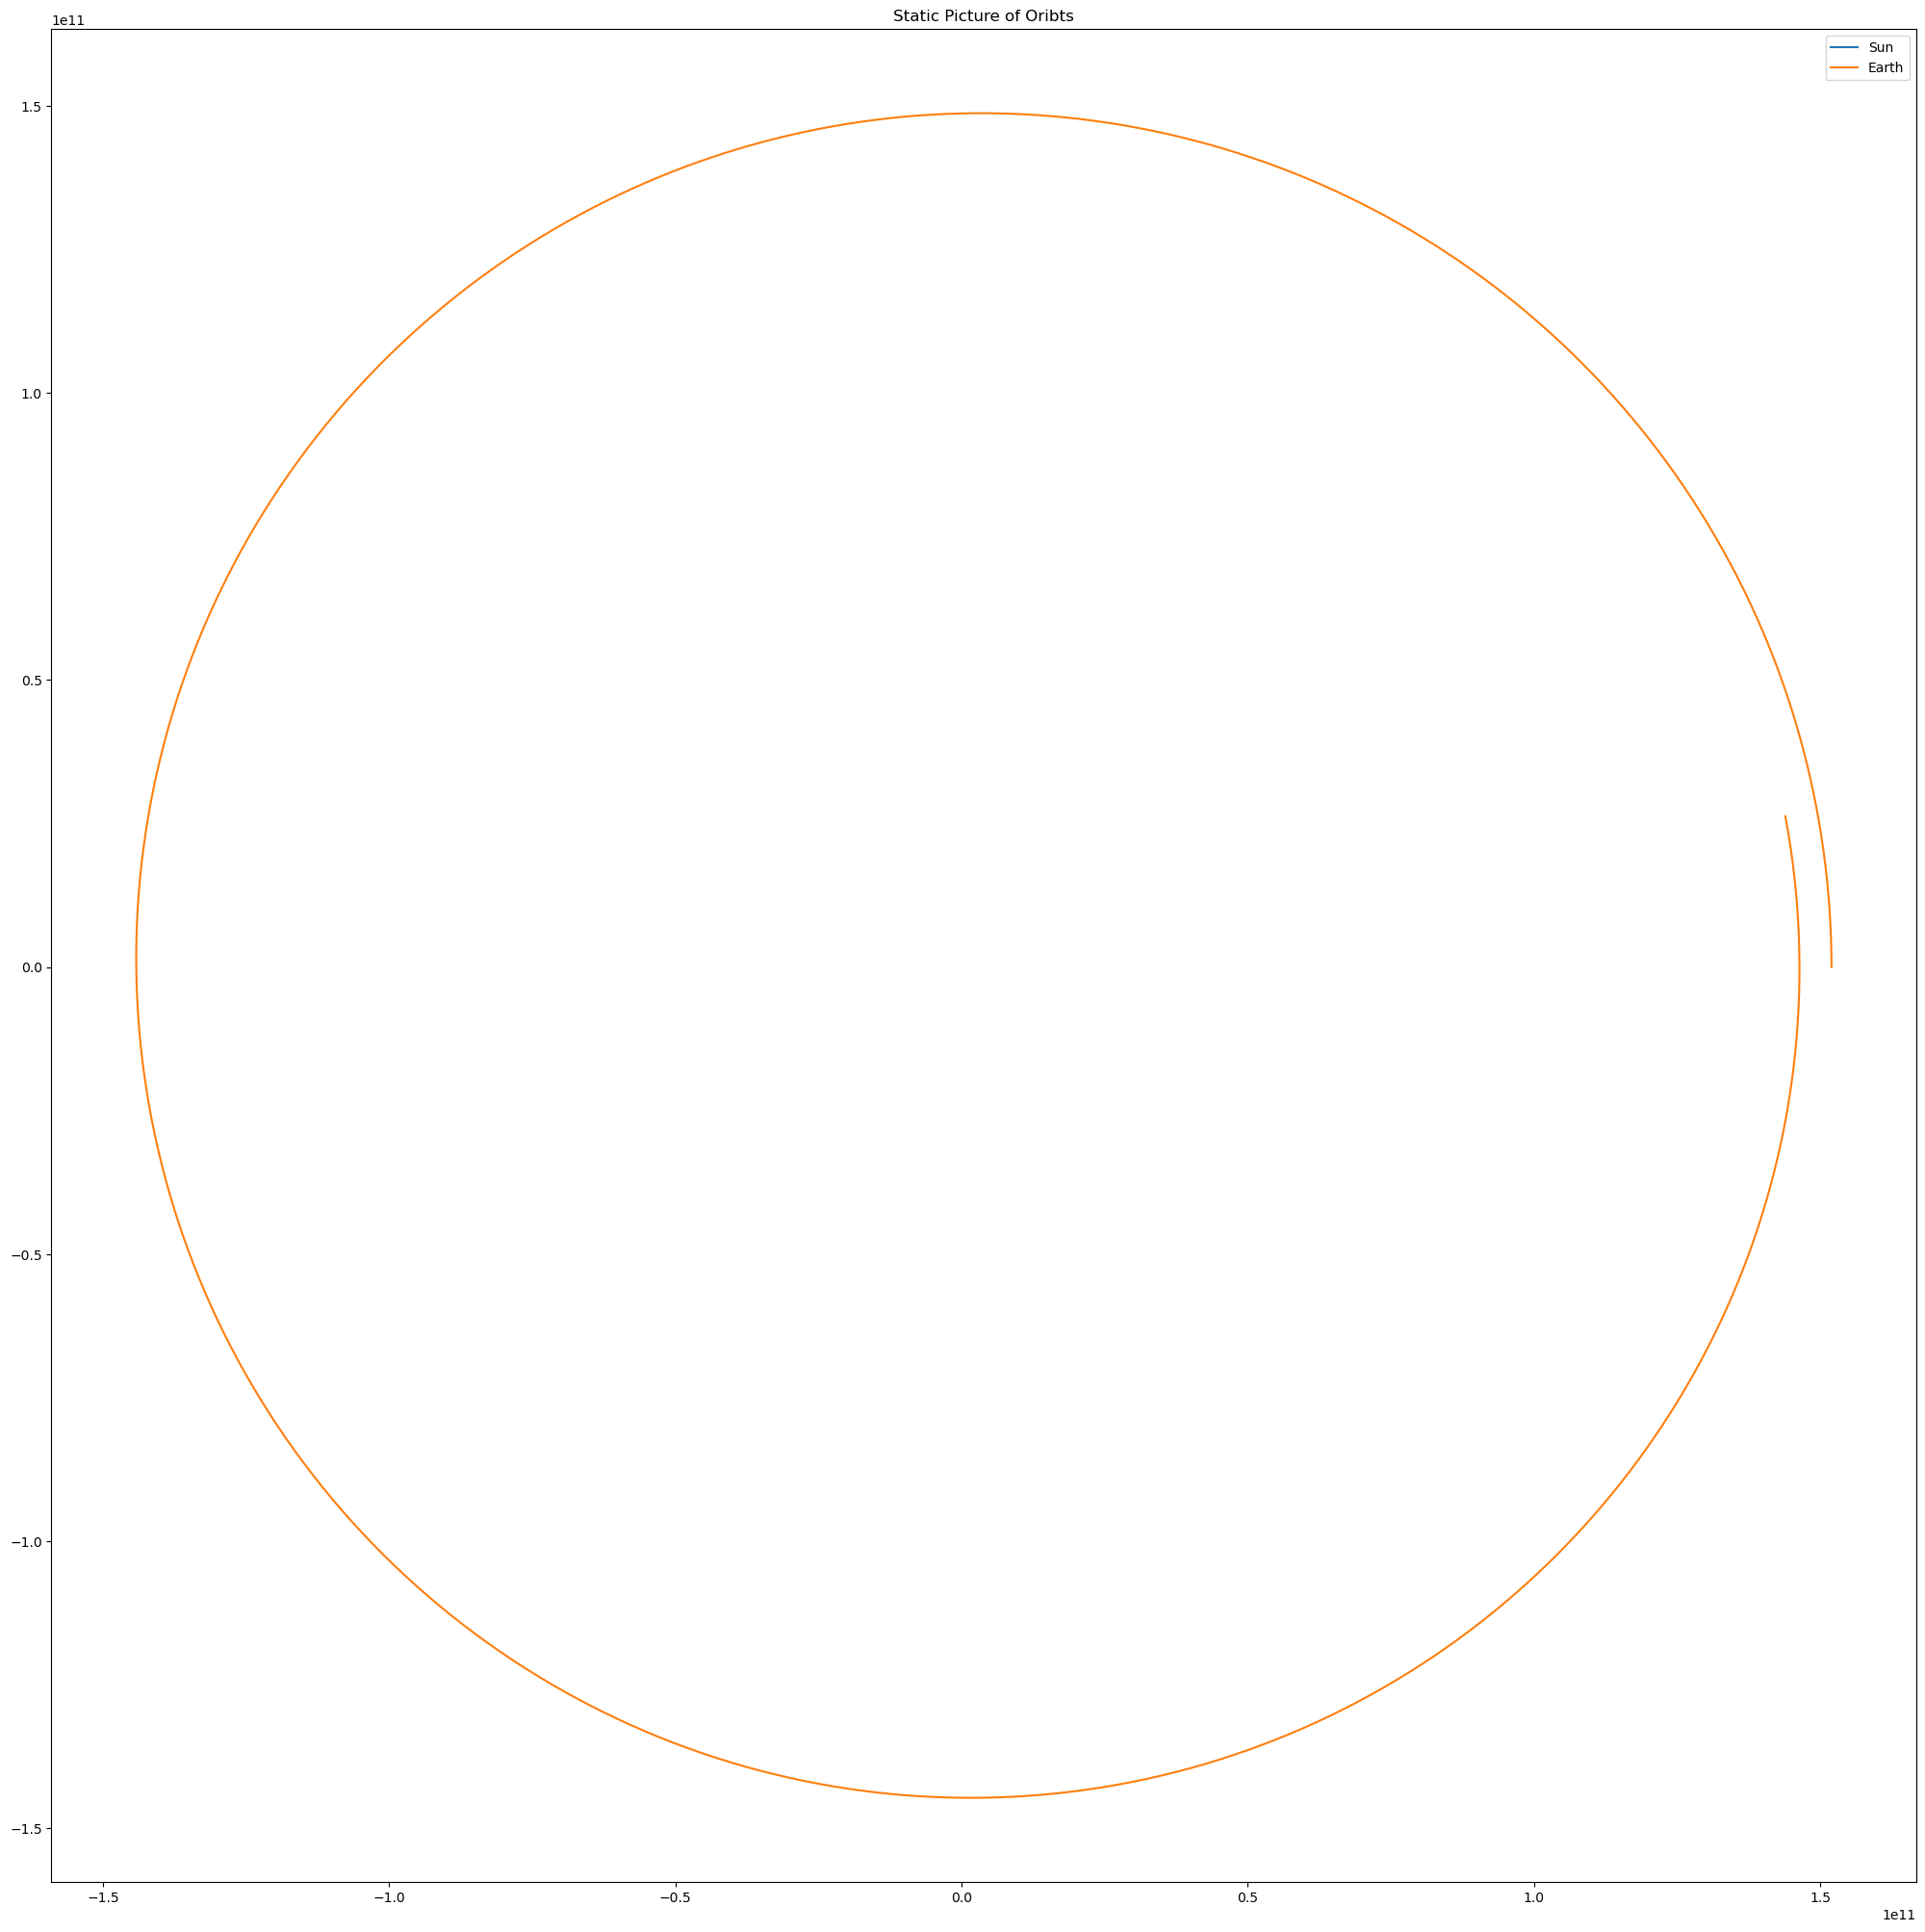

In [25]:
body: Wanderer
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
# plt.rcParams["figure.figsize"] = (75, 75)
plt.figure(figsize = (25, 25))

for body in system:
    plt.plot(body.rn[:, X], body.rn[:, Y], label = body._name)

plt.legend()
plt.title("Static Picture of Oribts")
plt.savefig(str(cwd / f"Static_Orbits_for_{YEARS}_years.png"))
plt.show()

Attempts at Animating the Plots

In [26]:
# from matplotlib.animation import FuncAnimation

# fig = plt.figure()
# ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
# line, = ax.plot([], [], lw=3)

# def init():
#     line.set_data([], [])
#     return line,
# def animate(i):
#     x = np.linspace(0, 4, 1000)
#     y = np.sin(2 * np.pi * (x - 0.01 * i))
#     line.set_data(x, y)
#     return line,

# anim = FuncAnimation(fig, animate, init_func=init,
#                                frames=200, interval=20, blit=True)


# anim.save('sine_wave.gif', writer='imagemagick')



In [27]:
# """
# This short code snippet utilizes the new animation package in
# matplotlib 1.1.0; it's the shortest snippet that I know of that can
# produce an animated plot in python. I'm still hoping that the
# animate package's syntax can be simplified further. 
# """
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation

# def simData():
# # this function is called as the argument for
# # the simPoints function. This function contains
# # (or defines) and iterator---a device that computes
# # a value, passes it back to the main program, and then
# # returns to exactly where it left off in the function upon the
# # next call. I believe that one has to use this method to animate
# # a function using the matplotlib animation package.
# #
#     t_max = 10.0
#     dt = 0.05
#     x = 0.0
#     t = 0.0
#     while t < t_max:
#         x = np.sin(np.pi*t)
#         t = t + dt
#         yield x, t

# def simPoints(simData):
#     x, t = simData[0], simData[1]
#     time_text.set_text(time_template%(t))
#     line.set_data(t, x)
#     return line, time_text

# ##
# ##   set up figure for plotting:
# ##
# fig = plt.figure()
# ax = fig.add_subplot(111)
# # I'm still unfamiliar with the following line of code:
# line, = ax.plot([], [], 'bo', ms=10)
# ax.set_ylim(-1, 1)
# ax.set_xlim(0, 10)
# ##
# time_template = 'Time = %.1f s'    # prints running simulation time
# time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
# ## Now call the animation package: (simData is the user function
# ## serving as the argument for simPoints):
# ani = animation.FuncAnimation(fig, simPoints, simData, blit=False,\
#      interval=10, repeat=True)
# plt.show()

In [28]:
# import chart_studio.plotly as py
# import numpy as np

# data = [dict(
#         visible = False,
#         line=dict(color='#00CED1', width=6),
#         name = '𝜈 = '+str(step),
#         x = np.arange(0,10,0.01),
#         y = np.sin(step*np.arange(0,10,0.01))) for step in np.arange(0,5,0.1)]
# data[10]['visible'] = True

# steps = []
# for i in range(len(data)):
#     step = dict(
#         method = 'restyle',
#         args = ['visible', [False] * len(data)],
#     )
#     step['args'][1][i] = True # Toggle i'th trace to "visible"
#     steps.append(step)

# sliders = [dict(
#     active = 10,
#     currentvalue = {"prefix": "Frequency: "},
#     pad = {"t": 50},
#     steps = steps
# )]

# layout = dict(sliders=sliders)
# fig = dict(data=data, layout=layout)

# py.iplot(fig, filename='Sine Wave Slider')